<a href="https://colab.research.google.com/github/burner129/mbfkan/blob/main/Singlevaranalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title KAN install and import for google colab


import sys, os, subprocess, textwrap

_ = subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "kan", "pykan"], stdout=subprocess.PIPE)

print("Installing pykan from GitHub...")
subprocess.check_call([sys.executable, "-m", "pip", "install", "-U", "git+https://github.com/KindXiaoming/pykan.git"])

try:
    import kan
    print("Imported 'kan' from pip:", getattr(kan, "__file__", "<no file>"))
except Exception as e:
    print("Pip install import failed:", e)
    print("Falling back to source checkout + sys.path import...")

    repo_dir = "/content/pykan"
    if not os.path.isdir(repo_dir):
        subprocess.check_call(["git", "clone", "https://github.com/KindXiaoming/pykan.git", repo_dir])

    if repo_dir not in sys.path:
        sys.path.append(repo_dir)

    import kan
    print("Imported 'kan' from source path:", getattr(kan, "__file__", "<no file>"))

from kan.spline import B_batch
import torch
x = torch.rand(10, 2)
grid = torch.linspace(-1, 1, steps=11)[None, :].expand(2, 11)
y = B_batch(x, grid, k=3)
print("B_batch OK, shape:", tuple(y.shape))

Installing pykan from GitHub...
Imported 'kan' from pip: /usr/local/lib/python3.12/dist-packages/kan/__init__.py
B_batch OK, shape: (10, 2, 7)


In [ ]:
#@title Import statements

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from typing import *
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import math
import kan
from kan.spline import *
from kan.utils import sparse_mask
from kan.Symbolic_KANLayer import Symbolic_KANLayer
import random
import torch.nn.functional as F

In [ ]:
#@title SineKANLayer

def forward_step(i_n, grid_size, A, K, C):
    ratio = A * grid_size**(-K) + C
    i_n1 = ratio * i_n
    return i_n1

class SineKANLayer(torch.nn.Module):
    def __init__(self, input_dim, output_dim, device='cuda', grid_size=5, is_first=False, add_bias=True, norm_freq=True):
        super(SineKANLayer,self).__init__()
        self.grid_size = grid_size
        self.device = device
        self.is_first = is_first
        self.add_bias = add_bias
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.A, self.K, self.C = 0.9724108095811765, 0.9884401790754128, 0.999449553483052

        self.grid_norm_factor = (torch.arange(grid_size) + 1)
        self.grid_norm_factor = self.grid_norm_factor.reshape(1, 1, grid_size)

        if is_first:
            self.amplitudes = torch.nn.Parameter(torch.empty(output_dim, input_dim, 1).normal_(0, .4) / output_dim  / self.grid_norm_factor)
        else:
            self.amplitudes = torch.nn.Parameter(torch.empty(output_dim, input_dim, 1).uniform_(-1, 1) / output_dim  / self.grid_norm_factor)

        grid_phase = torch.arange(1, grid_size + 1).reshape(1, 1, 1, grid_size) / (grid_size + 1)
        self.input_phase = torch.linspace(0, math.pi, input_dim).reshape(1, 1, input_dim, 1).to(device)
        phase = grid_phase.to(device) + self.input_phase

        if norm_freq:
            self.freq = torch.nn.Parameter(torch.arange(1, grid_size + 1).float().reshape(1, 1, 1, grid_size) / (grid_size + 1)**(1 - is_first))
        else:
            self.freq = torch.nn.Parameter(torch.arange(1, grid_size + 1).float().reshape(1, 1, 1, grid_size))

        for i in range(1, self.grid_size):
            phase = forward_step(phase, i, self.A, self.K, self.C)
        # self.phase = torch.nn.Parameter(phase)
        self.register_buffer('phase', phase)

        if self.add_bias:
            self.bias  = torch.nn.Parameter(torch.ones(1, output_dim) / output_dim)

    def forward(self, x):
        x_shape = x.shape
        output_shape = x_shape[0:-1] + (self.output_dim,)
        x = torch.reshape(x, (-1, self.input_dim))
        x_reshaped = torch.reshape(x, (x.shape[0], 1, x.shape[1], 1))
        s = torch.sin(x_reshaped * self.freq + self.phase)
        y = torch.einsum('ijkl,jkl->ij', s, self.amplitudes)
        if self.add_bias:
            y += self.bias
        y = torch.reshape(y, output_shape)
        return y

In [ ]:
#@title ChebyKANLayer


# This is inspired by Kolmogorov-Arnold Networks but using Chebyshev polynomials instead of splines coefficients
class ChebyKANLayer(nn.Module):
    def __init__(self, input_dim, output_dim, degree):
        super(ChebyKANLayer, self).__init__()
        self.inputdim = input_dim
        self.outdim = output_dim
        self.degree = degree

        self.cheby_coeffs = nn.Parameter(torch.empty(input_dim, output_dim, degree + 1))
        nn.init.normal_(self.cheby_coeffs, mean=0.0, std=1 / (input_dim * (degree + 1)))
        self.register_buffer("arange", torch.arange(0, degree + 1, 1))

    def forward(self, x):

        x = torch.tanh(x)

        x = x.view((-1, self.inputdim, 1)).expand(
            -1, -1, self.degree + 1
        )
        x = x.acos()

        x *= self.arange

        x = x.cos()

        y = torch.einsum(
            "bid,iod->bo", x, self.cheby_coeffs
        )
        y = y.view(-1, self.outdim)
        return y

In [ ]:
#@title WavKANLayer
class WavKANLinear(nn.Module):
    def __init__(self, in_features, out_features, wavelet_type='dog'):
        super(WavKANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.wavelet_type = wavelet_type

        self.scale = nn.Parameter(torch.ones(out_features, in_features))
        nn.init.uniform_(self.scale, a=0.5, b=2.0)

        self.translation = nn.Parameter(torch.zeros(out_features, in_features))

        #self.weight = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight1 = nn.Parameter(torch.Tensor(out_features, in_features)) #not used; you may like to use it for wieghting base activation and adding it like Spl-KAN paper
        self.wavelet_weights = nn.Parameter(torch.Tensor(out_features, in_features))

        nn.init.kaiming_uniform_(self.wavelet_weights, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.weight1, a=math.sqrt(5))

        self.base_activation = nn.SiLU()

        #self.bn = nn.BatchNorm1d(out_features)

    def wavelet_transform(self, x):
        if x.dim() == 2:
            x_expanded = x.unsqueeze(1)
        else:
            x_expanded = x

        translation_expanded = self.translation.unsqueeze(0).expand(x.size(0), -1, -1)
        scale_expanded = self.scale.unsqueeze(0).expand(x.size(0), -1, -1)
        x_scaled = (x_expanded - translation_expanded) / scale_expanded

        if self.wavelet_type == 'mexican_hat':
            term1 = ((x_scaled ** 2)-1)
            term2 = torch.exp(-0.5 * x_scaled ** 2)
            wavelet = (2 / (math.sqrt(3) * math.pi**0.25)) * term1 * term2
            wavelet_weighted = wavelet * self.wavelet_weights.unsqueeze(0).expand_as(wavelet)
            wavelet_output = wavelet_weighted.sum(dim=2)
        elif self.wavelet_type == 'morlet':
            omega0 = 5.0
            real = torch.cos(omega0 * x_scaled)
            envelope = torch.exp(-0.5 * x_scaled ** 2)
            wavelet = envelope * real
            wavelet_weighted = wavelet * self.wavelet_weights.unsqueeze(0).expand_as(wavelet)
            wavelet_output = wavelet_weighted.sum(dim=2)

        elif self.wavelet_type == 'dog':
            dog = -x_scaled * torch.exp(-0.5 * x_scaled ** 2)
            wavelet = dog
            wavelet_weighted = wavelet * self.wavelet_weights.unsqueeze(0).expand_as(wavelet)
            wavelet_output = wavelet_weighted.sum(dim=2)
        elif self.wavelet_type == 'meyer':
            v = torch.abs(x_scaled)
            pi = math.pi

            def meyer_aux(v):
                return torch.where(v <= 1/2,torch.ones_like(v),torch.where(v >= 1,torch.zeros_like(v),torch.cos(pi / 2 * nu(2 * v - 1))))

            def nu(t):
                return t**4 * (35 - 84*t + 70*t**2 - 20*t**3)
            wavelet = torch.sin(pi * v) * meyer_aux(v)
            wavelet_weighted = wavelet * self.wavelet_weights.unsqueeze(0).expand_as(wavelet)
            wavelet_output = wavelet_weighted.sum(dim=2)
        elif self.wavelet_type == 'shannon':
            pi = math.pi
            sinc = torch.sinc(x_scaled / pi)

            window = torch.hamming_window(x_scaled.size(-1), periodic=False, dtype=x_scaled.dtype, device=x_scaled.device)
            wavelet = sinc * window
            wavelet_weighted = wavelet * self.wavelet_weights.unsqueeze(0).expand_as(wavelet)
            wavelet_output = wavelet_weighted.sum(dim=2)
        else:
            raise ValueError("Unsupported wavelet type")

        return wavelet_output

    def forward(self, x):
        wavelet_output = self.wavelet_transform(x)

        #wav_output = F.linear(wavelet_output, self.weight)
        #base_output = F.linear(self.base_activation(x), self.weight1)

        base_output = F.linear(x, self.weight1)
        combined_output =  wavelet_output + base_output

        return combined_output


Training SineKAN...
[SineKAN | sin] Epoch 0, MSE Loss: 3.546452
[SineKAN | sin] Epoch 200, MSE Loss: 0.000395
[SineKAN | sin] Epoch 400, MSE Loss: 0.000111
[SineKAN | sin] Epoch 600, MSE Loss: 0.000169
[SineKAN | sin] Epoch 800, MSE Loss: 0.000085


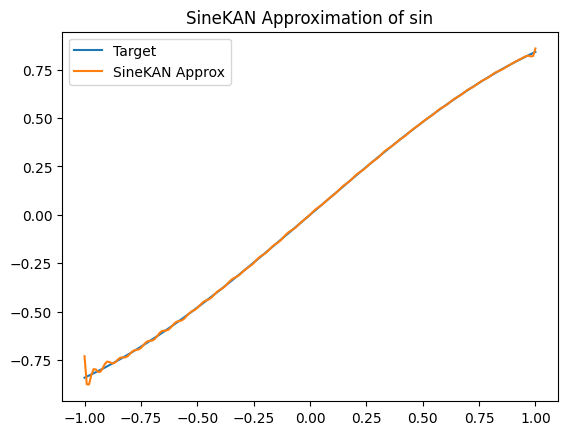

[SineKAN | cos] Epoch 0, MSE Loss: 0.981585
[SineKAN | cos] Epoch 200, MSE Loss: 0.000024
[SineKAN | cos] Epoch 400, MSE Loss: 0.000047
[SineKAN | cos] Epoch 600, MSE Loss: 0.000034
[SineKAN | cos] Epoch 800, MSE Loss: 0.000003


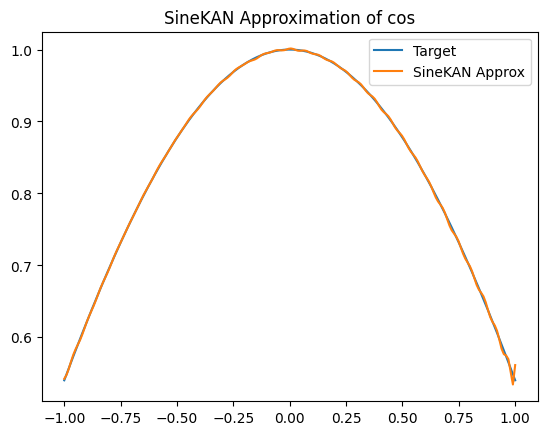

[SineKAN | square] Epoch 0, MSE Loss: 2.374815
[SineKAN | square] Epoch 200, MSE Loss: 0.000017
[SineKAN | square] Epoch 400, MSE Loss: 0.000047
[SineKAN | square] Epoch 600, MSE Loss: 0.000041
[SineKAN | square] Epoch 800, MSE Loss: 0.000003


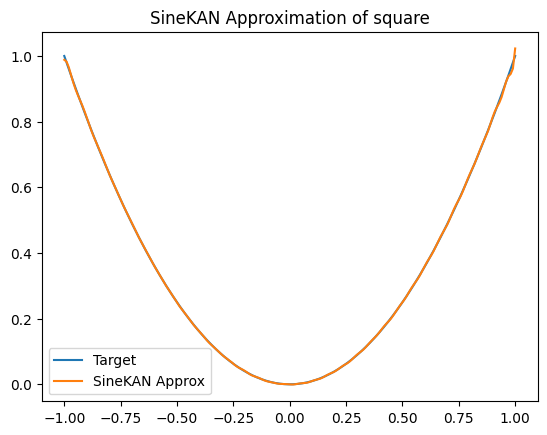

[SineKAN | gaussian] Epoch 0, MSE Loss: 1.174439
[SineKAN | gaussian] Epoch 200, MSE Loss: 0.000040
[SineKAN | gaussian] Epoch 400, MSE Loss: 0.000076
[SineKAN | gaussian] Epoch 600, MSE Loss: 0.000055
[SineKAN | gaussian] Epoch 800, MSE Loss: 0.000005


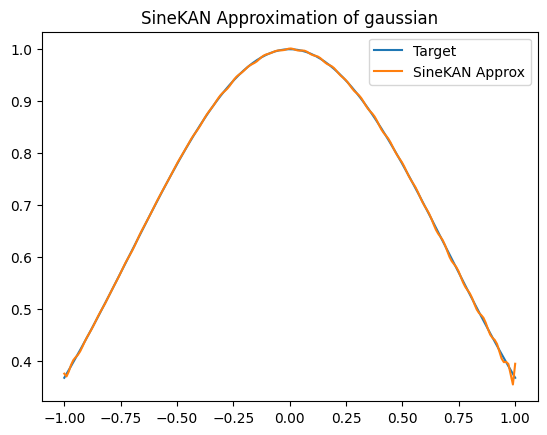

Training ChebyKAN...
[ChebyKAN | sin] Epoch 0, MSE Loss: 0.362826
[ChebyKAN | sin] Epoch 200, MSE Loss: 0.005471
[ChebyKAN | sin] Epoch 400, MSE Loss: 0.001593
[ChebyKAN | sin] Epoch 600, MSE Loss: 0.000219
[ChebyKAN | sin] Epoch 800, MSE Loss: 0.000015


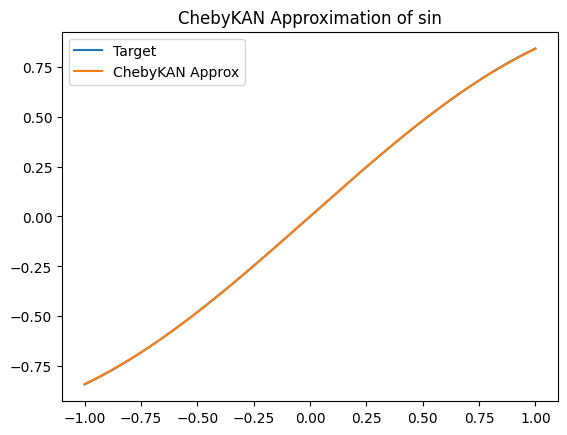

[ChebyKAN | cos] Epoch 0, MSE Loss: 0.633533
[ChebyKAN | cos] Epoch 200, MSE Loss: 0.000018
[ChebyKAN | cos] Epoch 400, MSE Loss: 0.000023
[ChebyKAN | cos] Epoch 600, MSE Loss: 0.000027
[ChebyKAN | cos] Epoch 800, MSE Loss: 0.000014


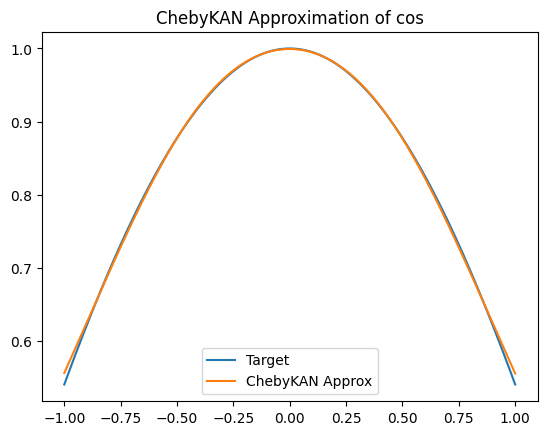

[ChebyKAN | square] Epoch 0, MSE Loss: 0.082258
[ChebyKAN | square] Epoch 200, MSE Loss: 0.005338


KeyboardInterrupt: 

In [ ]:
#@title TrainLayer function template (slightly modified from sinekan)

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

functions = {
    "sin": torch.sin,
    "cos": torch.cos,
    "square": lambda x: x**2,
    "gaussian": lambda x: torch.exp(-x**2),
}

def train_function_approximator(layer_class, name, functions, epochs=1000, batch=100, lr=0.01):
    all_y_vals = []

    for fname, function in functions.items():
        torch.manual_seed(42)

        if layer_class.__name__ == "SineKANLayer":
            op = layer_class(1, 1, grid_size=100, norm_freq=False).to(device)
        elif layer_class.__name__ == "ChebyKANLayer":
            op = layer_class(1, 1, degree=4).to(device)
        elif layer_class.__name__ == "WavKANLinear":
            base = layer_class(1, 128, wavelet_type='dog').to(device)
            readout = nn.Linear(128, 1).to(device)
            op = nn.Sequential(base, readout)
        else:
            raise ValueError(f"Unknown layer type: {layer_class}")

        opt = torch.optim.Adam(op.parameters(), lr=lr)
        criterion = nn.MSELoss()

        for ep in range(epochs):
            x = (torch.rand(batch).to(device) * 2 - 1).unsqueeze(-1)
            y0 = function(x).to(device)

            opt.zero_grad()
            y_pred = op(x)
            if isinstance(y_pred, tuple):
                y_pred = y_pred[0]
            loss = criterion(y_pred, y0)

            loss.backward()
            opt.step()

            if ep % 200 == 0:
                print(f"[{name} | {fname}] Epoch {ep}, MSE Loss: {loss.item():.6f}")

        with torch.no_grad():
            x = torch.linspace(-1., 1., 200).to(device).unsqueeze(-1)
            y0 = function(x).to(device)
            y = op(x)

        all_y_vals.append(y)


        plt.plot(x.cpu(), y0.cpu(), label="Target")
        plt.plot(x.cpu(), y.cpu(), label=f"{name} Approx")
        plt.title(f"{name} Approximation of {fname}")
        plt.legend()
        plt.show()

    return all_y_vals



print("Training SineKAN...")
train_function_approximator(SineKANLayer, "SineKAN", functions)

print("Training ChebyKAN...")
train_function_approximator(ChebyKANLayer, "ChebyKAN", functions)

print("Training WavKAN...")
train_function_approximator(WavKANLinear, "WavKAN", functions)


In [ ]:
def count_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
op = SineKANLayer(1, 1, grid_size=100, norm_freq=False, add_bias=False).to(device)
print("number of sinekanlayer params = ")
print(count_params(op))

op = ChebyKANLayer(3, 8, degree=10).to(device)
print("number of chebykanlayer params = ")
print(count_params(op))
base = WavKANLinear(3, 6, wavelet_type='dog').to(device)
print("number of wavkanlayer params = ")
print(count_params(base))

number of sinekanlayer params = 
200
number of chebykanlayer params = 
264
number of wavkanlayer params = 
72


number of sinekanlayer params = 
200
[SineKAN | sin] Epoch 0, MSE Loss: 1.090668
[SineKAN | sin] Epoch 200, MSE Loss: 0.000078
[SineKAN | sin] Epoch 400, MSE Loss: 0.000105
[SineKAN | sin] Epoch 600, MSE Loss: 0.000100
[SineKAN | sin] Epoch 800, MSE Loss: 0.000012
number of sinekanlayer params = 
200
[SineKAN | cos] Epoch 0, MSE Loss: 0.169381
[SineKAN | cos] Epoch 200, MSE Loss: 0.000002
[SineKAN | cos] Epoch 400, MSE Loss: 0.000006
[SineKAN | cos] Epoch 600, MSE Loss: 0.000003
[SineKAN | cos] Epoch 800, MSE Loss: 0.000002
number of sinekanlayer params = 
200
[SineKAN | square] Epoch 0, MSE Loss: 0.572547
[SineKAN | square] Epoch 200, MSE Loss: 0.000032
[SineKAN | square] Epoch 400, MSE Loss: 0.000020
[SineKAN | square] Epoch 600, MSE Loss: 0.000045
[SineKAN | square] Epoch 800, MSE Loss: 0.000021
number of sinekanlayer params = 
200
[SineKAN | cubic] Epoch 0, MSE Loss: 0.829491
[SineKAN | cubic] Epoch 200, MSE Loss: 0.000095
[SineKAN | cubic] Epoch 400, MSE Loss: 0.000055
[SineKAN | 

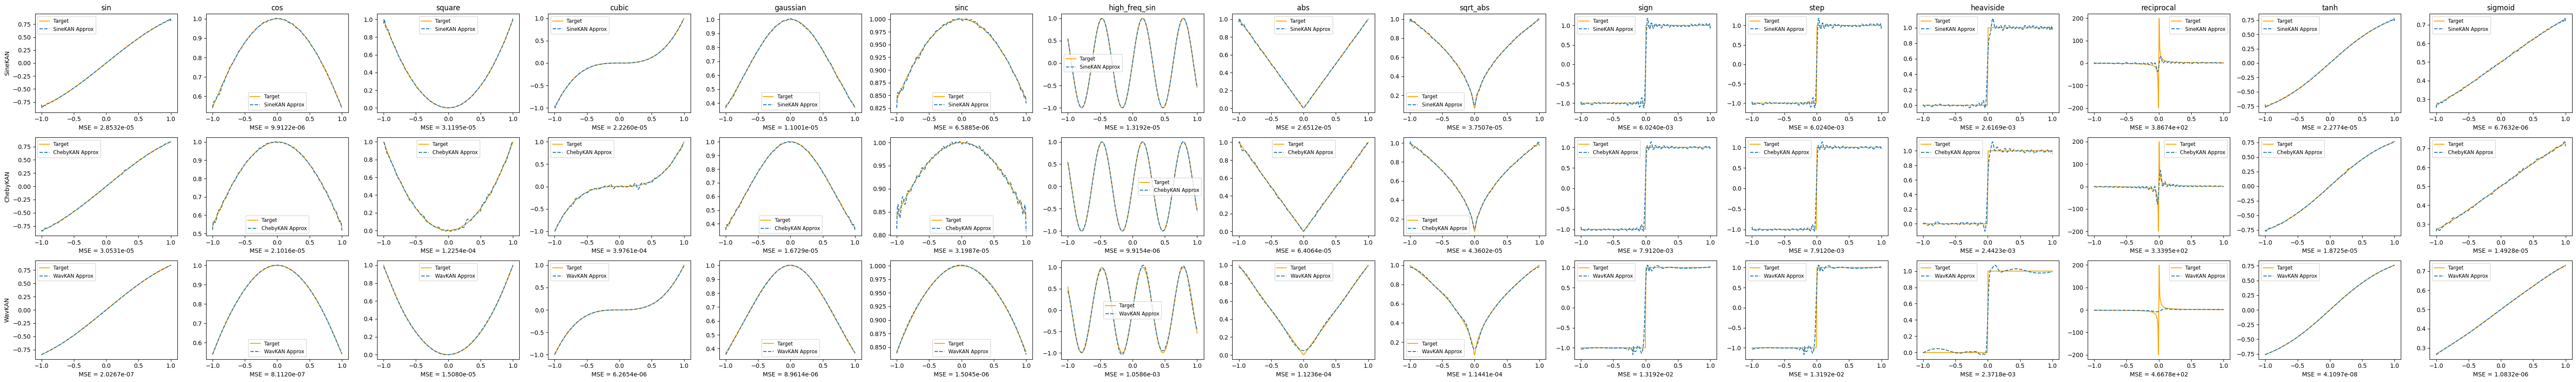

In [ ]:
#@title Custom Train layer function and analysis
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

functions = {
    # Smooth + simple
    "sin": torch.sin,
    "cos": torch.cos,
    "square": lambda x: x**2,
    "cubic": lambda x: x**3,
    "gaussian": lambda x: torch.exp(-x**2),

    # Oscillatory
    "sinc": lambda x: torch.sinc(x / torch.pi),
    "high_freq_sin": lambda x: torch.sin(10 * x),

    # Rough / non-smooth
    "abs": torch.abs,
    "sqrt_abs": lambda x: torch.sqrt(torch.abs(x) + 1e-6),
    "sign": torch.sign,

    # Discontinuous
    "step": lambda x: torch.where(x > 0, torch.tensor(1.0, device=x.device), torch.tensor(-1.0, device=x.device)),
    "heaviside": lambda x: torch.heaviside(x, torch.tensor(0.0, device=x.device)),
    "reciprocal": lambda x: torch.where(x != 0, 1.0 / x, torch.tensor(0.0, device=x.device)),

    # Nonlinear bounded
    "tanh": torch.tanh,
    "sigmoid": torch.sigmoid,
}


def train_function_approximator(layer_class, name, functions, epochs=1000, batch=100, lr=0.01):
    results = {}
    n_atoms = 28
    d = 100
    for fname, function in functions.items():
        torch.manual_seed(42)

        if layer_class.__name__ == "SineKANLayer":
            op = layer_class(1, 1, grid_size=100, norm_freq=False, add_bias=False).to(device)
            print("number of sinekanlayer params = ")
            print(count_params(op))
        elif layer_class.__name__ == "ChebyKANLayer":
            op = layer_class(1, 1, degree=d).to(device)
            print("number of chebykanlayer params = ")
            print(count_params(op))
        elif layer_class.__name__ == "WavKANLinear":
            base = layer_class(1, n_atoms, wavelet_type='dog').to(device)
            readout = layer_class(n_atoms, 1, wavelet_type='dog').to(device)
            op = nn.Sequential(base, readout)
            print("number of wavkanlayer params = ")
            print(count_params(op))
        elif layer_class.__name__ == "SplineKANLayer":
            op = kan.KANLayer(1, 1, grid_size=50).to(device)
            print("number of splkanlayer params = ")
            print(count_params(op))
        else:
            raise ValueError(f"Unknown layer type: {layer_class}")

        opt = torch.optim.Adam(op.parameters(), lr=lr)
        criterion = nn.MSELoss()

        for ep in range(epochs):
            x = (torch.rand(batch).to(device) * 2 - 1).unsqueeze(-1)
            y0 = function(x).to(device)

            opt.zero_grad()
            y = op(x)
            loss = criterion(y, y0)
            loss.backward()
            opt.step()

            if ep % 200 == 0:
                print(f"[{name} | {fname}] Epoch {ep}, MSE Loss: {loss.item():.6f}")

        with torch.no_grad():
            x = torch.linspace(-1., 1., 200).to(device).unsqueeze(-1)
            y0 = function(x).to(device)
            y = op(x)
            mse = criterion(y, y0).item()

        results[fname] = (x.cpu(), y0.cpu(), y.cpu(), mse)

    return results



all_results = {}
all_results["SineKAN"] = train_function_approximator(SineKANLayer, "SineKAN", functions)
all_results["ChebyKAN"] = train_function_approximator(ChebyKANLayer, "ChebyKAN", functions)
all_results["WavKAN"] = train_function_approximator(WavKANLinear, "WavKAN", functions)



n_rows = len(all_results)
n_cols = len(functions)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows), squeeze=False)

for r, (model_name, model_results) in enumerate(all_results.items()):
    for c, fname in enumerate(functions.keys()):
        ax = axes[r, c]
        x, y0, y, mse = model_results[fname]

        ax.plot(x, y0, label="Target", color="orange")
        ax.plot(x, y, label=f"{model_name} Approx", linestyle="--")
        if r == 0:
            ax.set_title(fname)
        if c == 0:
            ax.set_ylabel(model_name)

        ax.set_xlabel(f"MSE = {mse:.4e}")
        ax.legend(fontsize="small")

plt.tight_layout()
plt.show()
